In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import numpy as np

In [72]:
import pm4py

In [73]:
log = pm4py.read_xes('BPI_Challenge_2012.xes')
df = pm4py.convert_to_dataframe(log)

parsing log, completed traces :: 100%|██████████| 13087/13087 [00:10<00:00, 1269.91it/s]


In [74]:
# translating the Dutch phrases in the 'concept:name' column to English
translation_dict = {
    'W_Completeren aanvraag': 'W_Complete request',
    'W_Nabellen offertes': 'W_Follow up quotes',
    'W_Nabellen incomplete dossiers': 'W_Follow up incomplete files',
    'W_Valideren aanvraag': 'W_Validate request',
    'W_Afhandelen leads': 'W_Handle leads',
    'A_SUBMITTED': 'A_SUBMITTED',
    'A_PARTLYSUBMITTED': 'A_PARTLYSUBMITTED',
    'A_DECLINED': 'A_DECLINED',
    'A_PREACCEPTED': 'A_PREACCEPTED',
    'O_SENT': 'O_SENT',
    'O_CREATED': 'O_CREATED',
    'O_SELECTED': 'O_SELECTED',
    'A_ACCEPTED': 'A_ACCEPTED',
    'A_FINALIZED': 'A_FINALIZED',
    'O_CANCELLED': 'O_CANCELLED',
    'O_SENT_BACK': 'O_SENT_BACK',
    'A_CANCELLED': 'O_CANCELLED',
    'A_REGISTERED': 'A_REGISTERED',
    'A_ACTIVATED': 'A_ACTIVATED',
    'A_APPROVED': 'A_APPROVED',
    'O_ACCEPTED': 'O_ACCEPTED',
    'O_DECLINED': 'O_DECLINED',
    'W_Beoordelen fraude': 'W_Evaluate fraud',
    'W_Wijzigen contractgegevens': 'W_Modify contract details'
}

In [75]:
df['concept:name_eng'] = df['concept:name'].map(translation_dict)

In [76]:
# adding position to the dataframe
df['position'] = df.groupby('case:concept:name').cumcount() + 1

In [77]:
# Adding the next activity(concept:name) to the dataframe and if the next activity is not available, then it will be fill in with No_Activity
df['next_activity'] = df.groupby('case:concept:name')['concept:name'].shift(-1).fillna('No_Activity')

In [78]:
df.drop(['case:REG_DATE', 'case:AMOUNT_REQ', 'lifecycle:transition'], axis=1, inplace = True)

In [79]:
#df = pd.read_csv('baseline_df.csv')

In [80]:
date1 = pd.to_datetime(df['time:timestamp'], errors='coerce', format='%Y-%m-%d %H:%M:%S.%f%z')
date2 = pd.to_datetime(df['time:timestamp'], errors='coerce', format='%Y-%m-%d %H:%M:%S%z')
df['date'] = date1.fillna(date2)

In [81]:
df["date_milliseconds"] = (df['date'] - pd.Timestamp("1970-01-01", tz = "UTC")) // pd.Timedelta('1ms')

In [82]:
df["duration"] = df.groupby("case:concept:name")["date_milliseconds"].shift(-1) - df["date_milliseconds"]

#df["duration"] = df["duration"] / (1000 * 60 * 60)  # Convert milliseconds to hours


In [83]:
df.head(10)

,org:resource,concept:name,time:timestamp,case:concept:name,concept:name_eng,position,next_activity,date,date_milliseconds,duration
0,112,A_SUBMITTED,2011-10-01 00:38:44.546000+00:00,173688,A_SUBMITTED,1,A_PARTLYSUBMITTED,2011-10-01 00:38:44.546000+00:00,1317429524546,334.0
1,112,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+00:00,173688,A_PARTLYSUBMITTED,2,A_PREACCEPTED,2011-10-01 00:38:44.880000+00:00,1317429524880,53026.0
2,112,A_PREACCEPTED,2011-10-01 00:39:37.906000+00:00,173688,A_PREACCEPTED,3,W_Completeren aanvraag,2011-10-01 00:39:37.906000+00:00,1317429577906,969.0
3,112,W_Completeren aanvraag,2011-10-01 00:39:38.875000+00:00,173688,W_Complete request,4,W_Completeren aanvraag,2011-10-01 00:39:38.875000+00:00,1317429578875,39427562.0
4,NaN,W_Completeren aanvraag,2011-10-01 11:36:46.437000+00:00,173688,W_Complete request,5,A_ACCEPTED,2011-10-01 11:36:46.437000+00:00,1317469006437,356871.0
5,10862,A_ACCEPTED,2011-10-01 11:42:43.308000+00:00,173688,A_ACCEPTED,6,O_SELECTED,2011-10-01 11:42:43.308000+00:00,1317469363308,145935.0
6,10862,O_SELECTED,2011-10-01 11:45:09.243000+00:00,173688,O_SELECTED,7,A_FINALIZED,2011-10-01 11:45:09.243000+00:00,1317469509243,0.0
7,10862,A_FINALIZED,2011-10-01 11:45:09.243000+00:00,173688,A_FINALIZED,8,O_CREATED,2011-10-01 11:45:09.243000+00:00,1317469509243,1954.0
8,10862,O_CREATED,2011-10-01 11:45:11.197000+00:00,173688,O_CREATED,9,O_SENT,2011-10-01 11:45:11.197000+00:00,1317469511197,183.0
9,10862,O_SENT,2011-10-01 11:45:11.380000+00:00,173688,O_SENT,10,W_Nabellen offertes,2011-10-01 11:45:11.380000+00:00,1317469511380,174.0


In [84]:
# finding the average duration for each position
position_dict_time = {}
for j in range(1, 176):
    time = []
    for i in (df[df['position'] == j]).index:
        time.append(df["duration"].iloc[i])
    if len(time) > 0:
        position_dict_time[j] = sum(time)/len(time)

In [85]:
# adding the average duration to each position
df['predicted_next_timestamp_milliseconds'] = df['date_milliseconds'] + df['position'].map(lambda x: position_dict_time[x]).fillna(0)
#df["duration"] = df['position'].map(lambda x: position_dict_time[x]).fillna(0) 

In [86]:
df['predicted_next_timestamp'] = df['predicted_next_timestamp_milliseconds'].apply(lambda x: '%d' % x)

In [87]:
# convert the predicted_timestamp to datetime
df['predicted_next_timestamp'] = pd.to_datetime(df['predicted_next_timestamp'], unit='ms')

C:\Users\Aahaan\AppData\Local\Temp\ipykernel_2488\1815087631.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['predicted_next_timestamp'] = pd.to_datetime(df['predicted_next_timestamp'], unit='ms')


In [88]:
df['next_timestamp'] = df.groupby('case:concept:name')['time:timestamp'].shift(-1).fillna(0)
df['next_timestamp_milliseconds'] = df.groupby('case:concept:name')['date_milliseconds'].shift(-1).fillna(0)

In [89]:
df['next_timestamp_milliseconds'] = df['next_timestamp_milliseconds'].apply(lambda x: '%d' % x)
df['predicted_next_timestamp_milliseconds'] = df['predicted_next_timestamp_milliseconds'].apply(lambda x: '%d' % x)

In [90]:
df.set_index("position", inplace = True)
df["duration"] = df["duration"].fillna(0)
df

,org:resource,concept:name,time:timestamp,case:concept:name,concept:name_eng,next_activity,date,date_milliseconds,duration,predicted_next_timestamp_milliseconds,predicted_next_timestamp,next_timestamp,next_timestamp_milliseconds
position,,,,,,,,,,,,,
1,112,A_SUBMITTED,2011-10-01 00:38:44.546000+00:00,173688,A_SUBMITTED,A_PARTLYSUBMITTED,2011-10-01 00:38:44.546000+00:00,1317429524546,334.0,1317429525127,2011-10-01 00:39:35.680,2011-10-01 00:38:44.880000+00:00,1317429524880
2,112,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+00:00,173688,A_PARTLYSUBMITTED,A_PREACCEPTED,2011-10-01 00:38:44.880000+00:00,1317429524880,53026.0,1317429559891,2011-10-01 00:39:35.680,2011-10-01 00:39:37.906000+00:00,1317429577906
3,112,A_PREACCEPTED,2011-10-01 00:39:37.906000+00:00,173688,A_PREACCEPTED,W_Completeren aanvraag,2011-10-01 00:39:37.906000+00:00,1317429577906,969.0,1317429577906,2011-10-01 00:39:35.680,2011-10-01 00:39:38.875000+00:00,1317429578875
4,112,W_Completeren aanvraag,2011-10-01 00:39:38.875000+00:00,173688,W_Complete request,W_Completeren aanvraag,2011-10-01 00:39:38.875000+00:00,1317429578875,39427562.0,1317442585858,2011-10-01 04:15:51.808,2011-10-01 11:36:46.437000+00:00,1317469006437
5,NaN,W_Completeren aanvraag,2011-10-01 11:36:46.437000+00:00,173688,W_Complete request,A_ACCEPTED,2011-10-01 11:36:46.437000+00:00,1317469006437,356871.0,1317470103140,2011-10-01 11:54:36.928,2011-10-01 11:42:43.308000+00:00,1317469363308
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,112,A_PARTLYSUBMITTED,2012-02-29 23:51:17.423000+00:00,214376,A_PARTLYSUBMITTED,W_Afhandelen leads,2012-02-29 23:51:17.423000+00:00,1330559477423,43864.0,1330559512434,2012-02-29 23:50:51.136,2012-02-29 23:52:01.287000+00:00,1330559521287
3,112,W_Afhandelen leads,2012-02-29 23:52:01.287000+00:00,214376,W_Handle leads,W_Afhandelen leads,2012-02-29 23:52:01.287000+00:00,1330559521287,34485449.0,1330559521287,2012-02-29 23:53:02.208,2012-03-01 09:26:46.736000+00:00,1330594006736
4,11169,W_Afhandelen leads,2012-03-01 09:26:46.736000+00:00,214376,W_Handle leads,A_DECLINED,2012-03-01 09:26:46.736000+00:00,1330594006736,50382.0,1330607013719,2012-03-01 13:03:50.272,2012-03-01 09:27:37.118000+00:00,1330594057118


# The main code begins here:

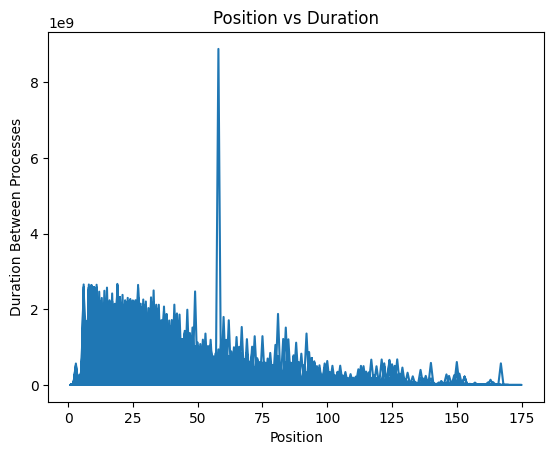

In [91]:
# Plot the time series
plt.plot(df["duration"])
plt.title("Position vs Duration")
plt.xlabel("Position")
plt.ylabel("Duration Between Processes")
plt.show()

The plot indicates a potential time trend

In [92]:
adf_test = adfuller(df["duration"])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])


ADF Statistic: -63.248519
p-value: 0.000000


In [93]:
for key, value in adf_test[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

Critial Values:
   1%, -3.430374946360248
Critial Values:
   5%, -2.8615510259755492
Critial Values:
   10%, -2.566775868727863


In [94]:
print('Number of Lags Used: %f' % adf_test[2])

Number of Lags Used: 62.000000


The optimal number of lags is 62

The ADF test indicates that there is no stationarity in the data as the p-value is lower than 0.05

This also means that differencing will not be neecessary and that an ARMA model can be used instead of ARIMA

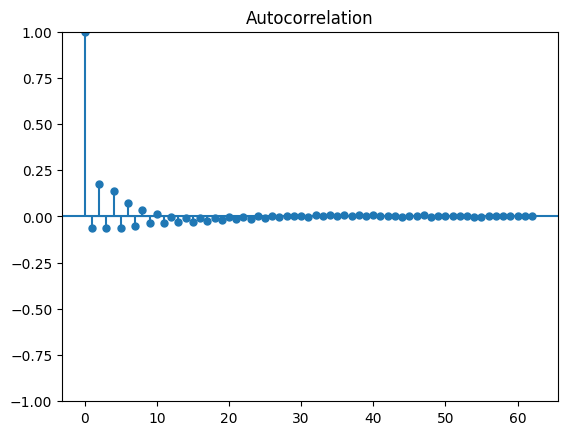

In [95]:
plot_acf(df["duration"], lags=62)
plt.show()

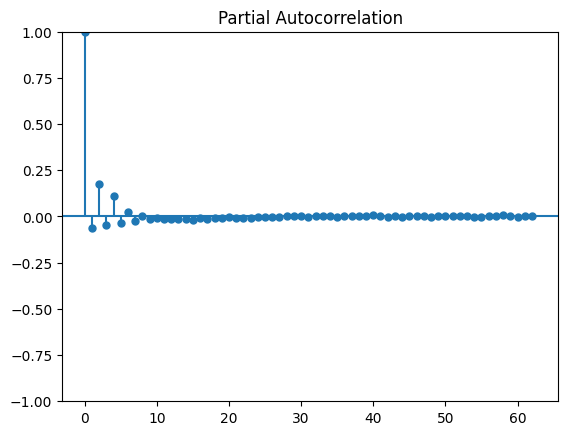

In [96]:
plot_pacf(df["duration"], lags=62)
plt.show()

In [97]:
# Fit the ARIMA(1,0,1) model

model = ARIMA(df["duration"], order=(1, 0, 1))
model_fit = model.fit()

c:\Users\Aahaan\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Aahaan\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Aahaan\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [98]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               duration   No. Observations:               262200
Model:                 ARIMA(1, 0, 1)   Log Likelihood            -5296512.432
Date:                Fri, 08 Mar 2024   AIC                       10593032.864
Time:                        10:00:08   BIC                       10593074.771
Sample:                             0   HQIC                      10593045.055
                             - 262200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.718e+07   2.34e-11   1.59e+18      0.000    3.72e+07    3.72e+07
ar.L1         -0.8811      0.004   -245.483      0.000      -0.888      -0.874
ma.L1          0.7905      0.004    175.785      0.0

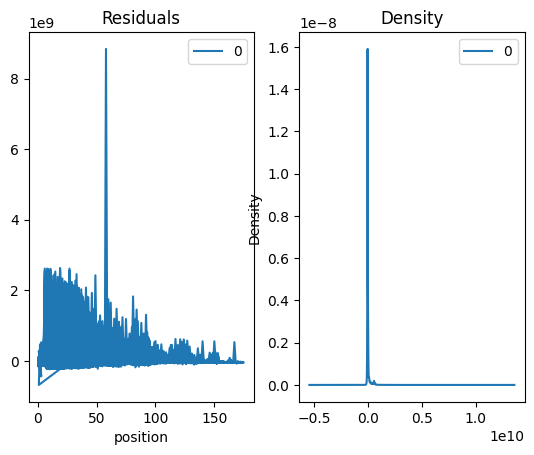

In [99]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [100]:
predictions = model_fit.predict()

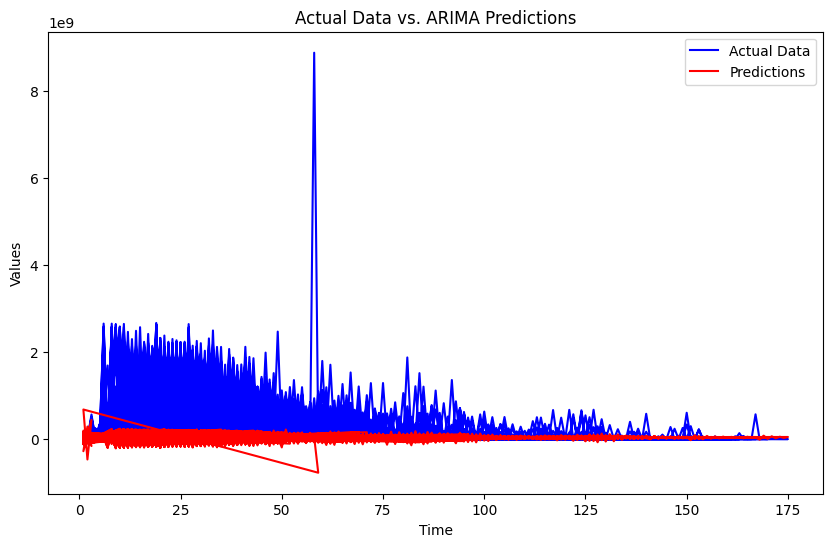

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(df["duration"], label='Actual Data', color='blue')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual Data vs. ARIMA Predictions')
plt.legend()
plt.show()

In [102]:
len(df)*0.8

209760.0

In [103]:
# Indicates the training data should end at position 33

x = pd.DataFrame(df.groupby(df.index)["duration"].count())

x.iloc[0:33]["duration"].sum()

212435

In [104]:
# Split the dataset into training and testing data

filtered_df = df[(df.index >= 0) & (df.index <= 33)]
filtered_df_2 = df[(df.index > 33)]

train = pd.DataFrame(filtered_df["duration"])
test = pd.DataFrame(filtered_df_2["duration"])

In [105]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 0, 1))  
fitted = model.fit()

# Training prediction
predictions = fitted.predict()

# Forecast
forecast = fitted.forecast(steps=len(test), index = test.index)



c:\Users\Aahaan\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Aahaan\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Aahaan\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


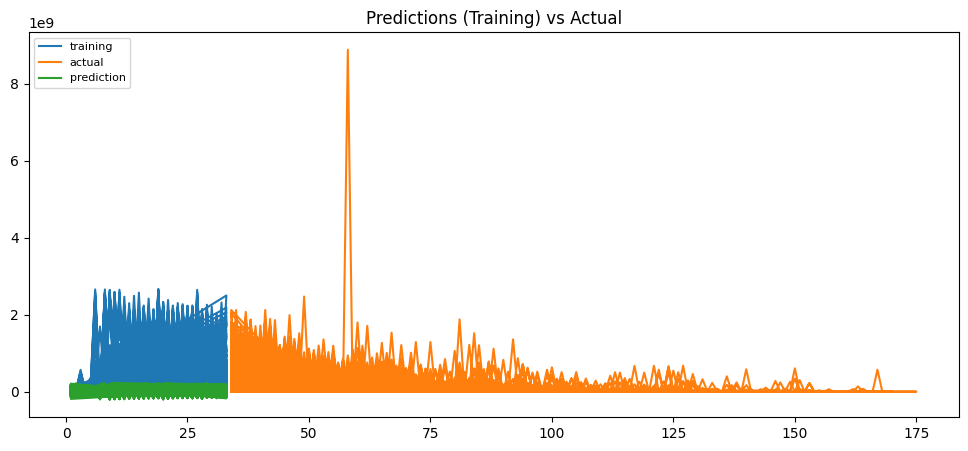

In [106]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(predictions, label='prediction')
plt.title('Predictions (Training) vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

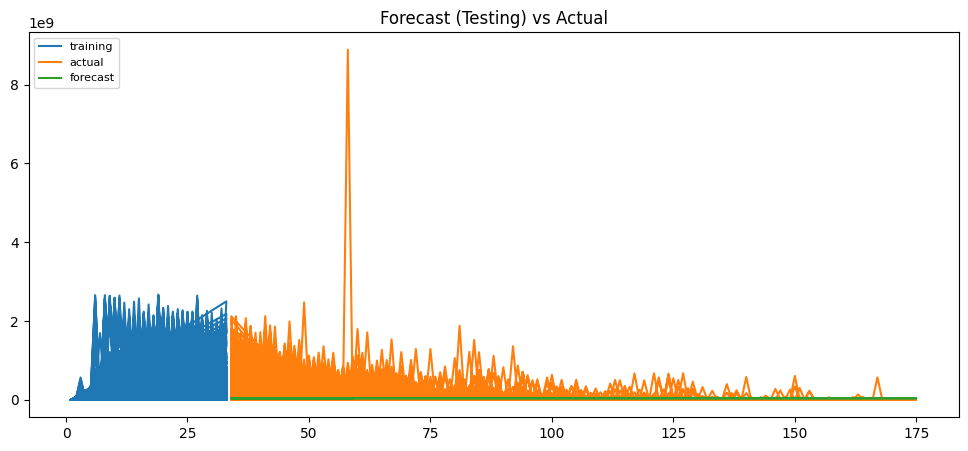

In [107]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(forecast, label='forecast')
plt.title('Forecast (Testing) vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
#  Automatically evaluates the best model based on the AIC

# Caution the code takes about 10 minutes to execute

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(df["duration"], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=32.95 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10618892.088, Time=1.38 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=10618892.904, Time=1.71 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10618893.274, Time=2.93 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10602422.793, Time=2.81 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=10601396.180, Time=3.52 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=10593333.405, Time=4.61 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=10592825.655, Time=5.98 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=10592348.616, Time=59.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=10592464.578, Time=34.55 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=10589574.907, Time=58.51 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=10589621.856, Time=39.77 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=10589403.757, Time=144.79 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1058959

In [108]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

mse_train = mean_squared_error(train, predictions)
mape_train = mean_absolute_percentage_error(train, predictions)

print("The mean squared error is: %f" %mse_train)
print("The mean absolute percentage error is: %f" %mape_train)

The mean squared error is: 21212819801555068.000000
The mean absolute percentage error is: 19743675535469918027776.000000


In [109]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

mse_test = mean_squared_error(test, forecast)
mape_test = mean_absolute_percentage_error(test, forecast)

print("The mean squared error is: %f" %mse_test)
print("The mean absolute percentage error is: %f" %mape_test)

The mean squared error is: 18670226665654648.000000
The mean absolute percentage error is: 25450008774192054403072.000000


In [110]:
# Evaluating variance
variance = np.var(forecast)

# Evaluating SSE
SSE = np.mean((np.mean(forecast) - test)** 2)  
  # O/P : 85.03300391390214

# Evaluating Variance
bias = SSE - Variance
  # O/P : 28.482148757577583

print(variance)
print(SSE)
print(bias)

3456231860.466408
1.8670117635733292e+16
1.867011417950143e+16


In [118]:
#from arch import arch_model

# Define model
##model = arch_model(train, mean='Zero', vol='ARCH', p=15)
# Fit model
##model_fit = model.fit()
# Forecast the test set
#yhat = model_fit.forecast(horizon=n_test)




37180473.51628146

In [30]:
#import pm4py

#if __name__ == "__main__":
#    log = pm4py.read_xes('BPI_Challenge_2012.xes')


In [31]:
#map = pm4py.discover_heuristics_net(log)
#pm4py.view_heuristics_net(map)

In [32]:
#df

In [33]:
#from sklearn.preprocessing import OneHotEncoder

#enc = OneHotEncoder(handle_unknown='ignore')

#enc.fit(df[["concept:name"]])

#array = enc.transform(df[["concept:name"]]).toarray()

#df_one_hot = pd.DataFrame(array, columns = enc.get_feature_names_out())

In [34]:
#df = df.merge(df_one_hot, left_index = True, right_index = True)
#df

In [35]:
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error

#X = df[[enc.get_feature_names_out()]]
#y = df["Duration"]




In [36]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
#model = LinearRegression()
#model.fit(X_train, y_train)

# Make predictions on the testing set
#y_pred = model.predict(X_test)

# Evaluate model
#mse = mean_squared_error(y_test, y_pred)
#print("Mean Squared Error:", mse)